**Goal:** Demonstrate the concept of KV (Key-Value) caching in self-attention mechanisms to improve inference speed and analyze its memory implications.

Minimal self-attention

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
class TinyAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, K_cache=None, V_cache=None):
        Q = self.Wq(x)

        if K_cache is None:
            K = self.Wk(x)
            V = self.Wv(x)
        else:
            K = torch.cat([K_cache, self.Wk(x)], dim=0)
            V = torch.cat([V_cache, self.Wv(x)], dim=0)

        scores = Q @ K.T / np.sqrt(Q.size(-1))
        scores = torch.tril(scores)  # causal
        attn = torch.softmax(scores, dim=-1)
        out = attn @ V
        return out, K, V

Decode WITHOUT KV cache

In [3]:
def decode_no_cache(model, x):
    outputs = []
    for t in range(x.size(0)):
        out, _, _ = model(x[:t+1])
        outputs.append(out[-1])
    return torch.stack(outputs)

Decode WITH KV cache

In [4]:
def decode_with_cache(model, x):
    outputs = []
    K_cache, V_cache = None, None

    for t in range(x.size(0)):
        out, K_cache, V_cache = model(
            x[t:t+1],
            K_cache,
            V_cache
        )
        outputs.append(out[-1])

    return torch.stack(outputs)

Measure speedup

In [5]:
seq_len = 256
d_model = 64
x = torch.randn(seq_len, d_model)
model = TinyAttention(d_model)

# Warmup
decode_no_cache(model, x)
decode_with_cache(model, x)

# Timing
t0 = time.time()
decode_no_cache(model, x)
t1 = time.time()

t2 = time.time()
decode_with_cache(model, x)
t3 = time.time()

print("No cache time:", round(t1 - t0, 4), "s")
print("With cache time:", round(t3 - t2, 4), "s")

No cache time: 0.1066 s
With cache time: 0.0394 s


Cache hits vs misses

In [6]:
hits = []
misses = []

for t in range(seq_len):
    if t == 0:
        misses.append(1)
        hits.append(0)
    else:
        misses.append(1)   # new token
        hits.append(t)     # cached tokens reused

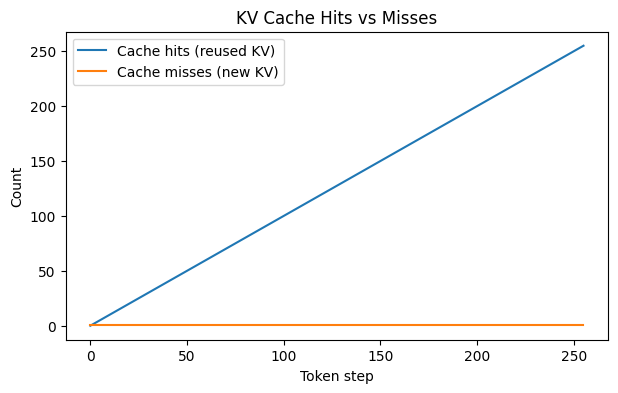

In [7]:
plt.figure(figsize=(7,4))
plt.plot(hits, label="Cache hits (reused KV)")
plt.plot(misses, label="Cache misses (new KV)")
plt.xlabel("Token step")
plt.ylabel("Count")
plt.title("KV Cache Hits vs Misses")
plt.legend()
plt.show()

Attention matrix growth WITH cache

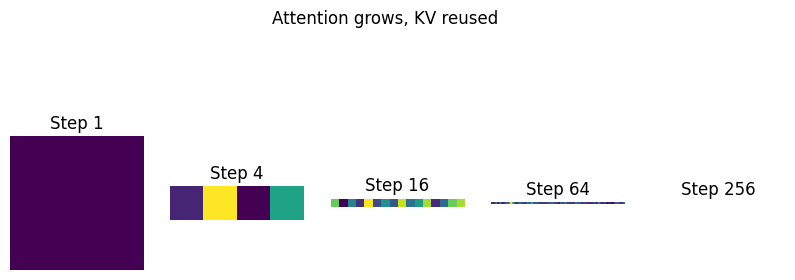

In [8]:
sizes = [1, 4, 16, 64, 256]

plt.figure(figsize=(10,4))
for i, s in enumerate(sizes):
    Q = x[s-1:s] @ model.Wq.weight.T
    K = x[:s] @ model.Wk.weight.T
    attn = torch.softmax(Q @ K.T / np.sqrt(d_model), dim=-1)

    plt.subplot(1, len(sizes), i+1)
    plt.imshow(attn.detach())
    plt.title(f"Step {s}")
    plt.axis("off")

plt.suptitle("Attention grows, KV reused")
plt.show()

Memory cost of KV cache
KV cache cost per layer:

```
memory = 2 × 𝐿 × 𝑑 model × 𝑑 memory
```

Let’s plot it.

In [9]:
#Compute memory usage
def kv_cache_mb(seq_len, d_model, layers=12, bytes_per_param=2):
    return (2 * seq_len * d_model * layers * bytes_per_param) / 1e6

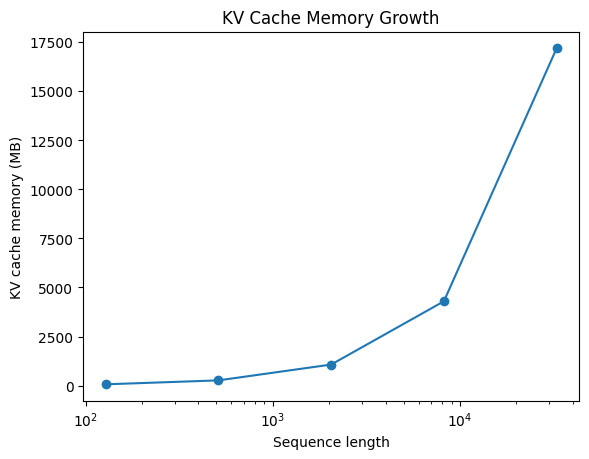

In [10]:
#Plot short vs long contexts
lengths = [128, 512, 2048, 8192, 32768]
memory = [kv_cache_mb(l, 4096, layers=32) for l in lengths]

plt.plot(lengths, memory, marker='o')
plt.xlabel("Sequence length")
plt.ylabel("KV cache memory (MB)")
plt.title("KV Cache Memory Growth")
plt.xscale("log")
plt.show()

##Notebook Summary

**Acheived:**

*   Demonstrated significant speedup when decoding with KV caching compared to without it.
*   Visualized cache hits and misses, showing how previously computed KV pairs are reused.
*   Illustrated the growth of the attention matrix with caching, highlighting the reuse of KV pairs across decoding steps.

**Goal:** A clear understanding of the performance benefits and memory considerations of KV caching in self-attention, highlighting its efficiency for sequential decoding and its linear memory growth with sequence length.


